# Error, interpolation and projection
Consider the Poisson problem on the domain $\Omega = [0,1] \times [0,1]$, source term f and thermal diffusivity $\kappa$. Find U satisfying


$$
\begin{split}
-\nabla \cdot (\kappa(x) \nabla u(x)) & = f(x), x \in \Omega\\
u(x) & = cos(2\pi x_1)cos(2 \pi x_2)
\end{split}
$$

Making $\kappa = 1$, $f = 8\pi^2 cos(2\pi x_1)cos(2\pi x_2)$, the exact solution reads

$$
u(x) = cos(2\pi x_1)cos(2\pi x_2)
$$

The solution $u_h$ is sought in a finite dimensional space $V_h \subset H^1(\Omega)$, made up of polynomial functions of degree k. In the variational formulation one looks for $u_h in V_h$ such that
$$
\int_{\Omega} \nabla u_h \cdot \nabla v_h dx \int_{\Omega} f v_h dx
$$

In the following, the problem is solved, in different settings (with different mesh refinements and different $V_h$s), and then it is computed the errors L2 and H1 and the runtime of each running, as an effort to develop a way to determine which setting to use in a situation.

In [1]:
## Importing libraries

from dolfin import *
from mshr import *
import numpy
from datetime import datetime
import csv
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

### User defined parameters
#### Set the following parameters according to your problem

In [28]:
space_dim = 2

Lx = 1.0
Ly = 1.0

fileio = 'pvd'
dir_ = './results'

if not os.path.exists(dir_):
    os.mkdir(dir_)

if(space_dim == 2):
   domain = Rectangle(Point(0.0,0.0), Point(Lx,Ly))
else:
   sys.exit("space_dim.eq.3 not implemented")

# Thermal conductivity
k = 1.0
kappa = Constant(k)

# In order to do time averaging
times = 3 

### Set the problem and solve it, recording relevant info

In [50]:
# Order of finite elements space
orders = [1,2,3]
mesh_refinements = [20,40,80,160]
elapsed_time = []

for t in range(times):
    # For remembering relevant info
    elapsed_time.append([])

    errorsH1        = []
    errorsL2        = []
    errors_interpL2 = []
    errors_interpH1 = []
    unknowns        = []
    hmax            = []

    for io, order in enumerate(orders):
        elapsed_time[t].append([])
        errorsH1.append([])
        errorsL2.append([])
        errors_interpH1.append([])
        errors_interpL2.append([])
        unknowns.append([])
        hmax.append([])
        for im, mesh_refinement in enumerate(mesh_refinements):

            Pk = FiniteElement("Lagrange", 'triangle', order)

            #### IO setup
            ufile_pvd  = File(dir_+f'/temperatureO{order}mr{mesh_refinement}.pvd')
            domfile_pvd = File(dir_+f"/auxfuncO{order}mr{mesh_refinement}.pvd")

            startTime = datetime.now()
            print(f'\n   ::> Begin computations for order {order} and refinement {mesh_refinement} at {t}')


            #### Mesh generation
            mesh = generate_mesh(domain, mesh_refinement)
            mesh = UnitSquareMesh.create(mesh_refinement, 
                                     mesh_refinement, 
                                     CellType.Type.triangle)

            #print("    |-Mesh done")
            #print("    |--Number of vertices = "+str(mesh.num_vertices()))
            #print("    |--Number of cells = "+str(mesh.num_cells()))
            #print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))


            # Finite element space
            W = FunctionSpace(mesh, Pk)
            print("    |--Total number of unknowns = %d" % (W.dim()))
            unknowns[io].append(W.dim())

            ### Variational formulation: Poisson problem
            u = TrialFunction(W)
            v = TestFunction(W)

            funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
            dx = Measure("dx")(subdomain_data=funcdom)
            #dx = Measure("dx")

            # Volumetric source
            f = Expression("8*pow(pi,2)*cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)

            a = inner(kappa*grad(u), grad(v))*dx
            L = f*v*dx

            #### Dirichlet boundary conditions on W
            Tboundary = Expression("cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)
            bcs = DirichletBC(W, Tboundary, DomainBoundary())


            ### Solution
            w = Function(W)

            # For Mesh refinement
            # problem = LinearVariationalProblem(a, L, w, bcs)
            # solver = LinearVariationalSolver(problem)
            # prm = solver.parameters
            # linear_solver = 'Krylov'
            # if linear_solver == 'Krylov':
            #     prm ["linear_solver"]= "gmres"
            #     prm ["preconditioner"]= "ilu"
            #     prm ["krylov_solver"]["absolute_tolerance"]= 1e-11
            #     prm ["krylov_solver"]["relative_tolerance"]= 1e-10
            #     prm ["krylov_solver"]["maximum_iterations"]= 10000
            #     prm ["krylov_solver"]["monitor_convergence"]= True
            #     prm ["krylov_solver"]["nonzero_initial_guess"]= True
            # else :
            #     prm ["linear_solver"]= "mumps"

            # solver.solve()
            solve(a == L, w, bcs)
            #      solver_parameters={'linear_solver':'gmres', 'preconditioner':'ilu'})

            ####### IO
            ufile_pvd << w
            domfile_pvd << funcdom

            elapsed_time[t][io].append(datetime.now() - startTime)
            #print('\n    ::> Elapsed time: ', str(elapsed_time[io][im]), '\n')


            # plt.figure(figsize=(15,15))
            # plot(mesh,linewidth=.2)
            # c = plot(w, wireframe=True, title=f'Solution')
            # plt.colorbar(c)
            # plt.show()

            hmax[io].append(mesh.hmax())

            #### Compute errors
            uexact = Expression('cos(2*pi*x[0])*cos(2*pi*x[1])', degree = 7)
            errorsH1[io].append(errornorm(uexact, w, 'H1'))
            errorsL2[io].append(errornorm(uexact, w, 'L2'))


            # Interpolate exact solution and compute interpolation error
            W = FunctionSpace (mesh, Pk)

            uinter = interpolate(uexact , W)
            errors_interpH1[io].append(errornorm(uexact, w, 'H1'))
            errors_interpL2[io].append(errornorm(uexact, w, 'L2'))


   ::> Begin computations for order 1 and refinement 20 at 0
    |--Total number of unknowns = 441

   ::> Begin computations for order 1 and refinement 40 at 0
    |--Total number of unknowns = 1681

   ::> Begin computations for order 1 and refinement 80 at 0
    |--Total number of unknowns = 6561

   ::> Begin computations for order 1 and refinement 160 at 0
    |--Total number of unknowns = 25921

   ::> Begin computations for order 2 and refinement 20 at 0
    |--Total number of unknowns = 1681

   ::> Begin computations for order 2 and refinement 40 at 0
    |--Total number of unknowns = 6561

   ::> Begin computations for order 2 and refinement 80 at 0
    |--Total number of unknowns = 25921

   ::> Begin computations for order 2 and refinement 160 at 0
    |--Total number of unknowns = 103041

   ::> Begin computations for order 3 and refinement 20 at 0
    |--Total number of unknowns = 3721

   ::> Begin computations for order 3 and refinement 40 at 0
    |--Total number of u

### Framing the data

In [63]:
idx = [1,2,3] # for indexing the dataframes' rows


elapsed_time_df0 = pd.DataFrame(data = [[time.total_seconds() for time in el] for el in elapsed_time[0]],
                               columns = mesh_refinements,
                               index = idx)

elapsed_time_df1 = pd.DataFrame(data = [[time.total_seconds() for time in el] for el in elapsed_time[1]],
                               columns = mesh_refinements,
                               index = idx)

elapsed_time_df2 = pd.DataFrame(data = [[time.total_seconds() for time in el] for el in elapsed_time[2]],
                               columns = mesh_refinements,
                               index = idx)

In [68]:
elapsed_time_df2.describe()

,20,40,80,160
count,3.000000,3.000000,3.000000,3.000000
mean,0.055476,0.335549,0.823233,3.524624
std,0.031796,0.259176,0.613829,2.621540
min,0.026605,0.138238,0.408401,1.410543
25%,0.038436,0.188787,0.470666,2.057958
50%,0.050268,0.239337,0.532932,2.705373
75%,0.069911,0.434205,1.030648,4.581664
max,0.089554,0.629073,1.528365,6.457955


[None, None]

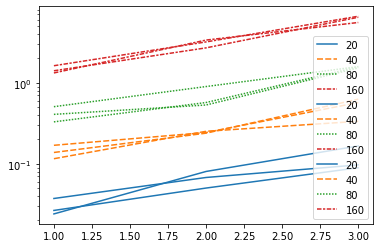

In [65]:
grid = sns.lineplot(data=elapsed_time_df0)
grid.set(xscale="linear", yscale="log")

grid = sns.lineplot(data=elapsed_time_df1)
grid.set(xscale="linear", yscale="log")

grid = sns.lineplot(data=elapsed_time_df2)
grid.set(xscale="linear", yscale="log")

In [39]:
errorsH1_df  = pd.DataFrame(data = errorsH1,
                            columns = mesh_refinements,
                            index = [1,2,3])


errorsL2_df  = pd.DataFrame(data = errorsL2,
                            columns = mesh_refinements,
                            index = [1,2,3])


errors_interpL2_df  = pd.DataFrame(data = errors_interpL2,
                                   columns = mesh_refinements,
                                   index = [1,2,3])


errors_interpH1_df  = pd.DataFrame(data = errors_interpH1,
                                   columns = mesh_refinements,
                                   index = [1,2,3])


unknowns_df  = pd.DataFrame(data = unknowns,
                            columns = mesh_refinements,
                            index = [1,2,3])


hmax_df  = pd.DataFrame(data = hmax,
                        columns = mesh_refinements,
                        index = [1,2,3])

errorsH1_df

ValueError: 3 columns passed, passed data had 9 columns

[None, None]

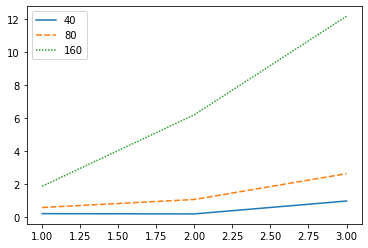

In [24]:
grid = sns.lineplot(data=elapsed_time_df)
grid.set(xscale="linear", yscale="linear")

In [21]:
elapsed_time_df

,40,80,160
1,0.218028,0.589904,1.873623
2,0.202073,1.075057,6.194414
3,0.981885,2.636196,12.147193


In [129]:
errorsL2_df

,40,80,160
1,0.007136,1.673595e-03,4.377572e-04
2,0.000128,1.573341e-05,1.963030e-06
3,0.000002,1.378058e-07,8.800856e-09


In [130]:
errors_interpL2_df

,40,80,160
1,0.007136,1.673595e-03,4.377572e-04
2,0.000128,1.573341e-05,1.963030e-06
3,0.000002,1.378058e-07,8.800856e-09


In [131]:
errors_interpH1_df

,40,80,160
1,0.659578,0.331560,0.165164
2,0.025271,0.006312,0.001575
3,0.000633,0.000078,0.000010


In [149]:
hmax_df

,40,80,160
1,0.049998,0.024998,0.0125
2,0.049998,0.024998,0.0125
3,0.049998,0.024998,0.0125


### Solve with quadrilateral elements

In [150]:
# For remembering relevant info
Qelapsed_time  = []
QerrorsH1      = []
QerrorsL2      = []
Qerrors_interp = []
Qunknowns      = []
Qhmax          = []

# Order of finite elements space
orders = [1,2,3]
mesh_refinements = [40,80,160]

for io, order in enumerate(orders):
    Qelapsed_time.append([])
    QerrorsH1.append([])
    QerrorsL2.append([])
    Qerrors_interp.append([])
    Qunknowns.append([])
    Qhmax.append([])
    
    for im, mesh_refinement in enumerate(mesh_refinements):
        
        Qk = FiniteElement("Lagrange", 'quadrilateral', order)

        #### IO setup
        ufile_pvd  = File(dir_+f'/QtemperatureO{order}mr{mesh_refinement}.pvd')
        domfile_pvd = File(dir_+f"/QauxfuncO{order}mr{mesh_refinement}.pvd")

        startTime = datetime.now()
        print(f'\n   ::> Begin computations for order {order} and refinement {mesh_refinement}')


        #### Mesh generation
        mesh = UnitSquareMesh.create(mesh_refinement, 
                                     mesh_refinement, 
                                     CellType.Type.quadrilateral)

        #print("    |-Mesh done")
        #print("    |--Number of vertices = "+str(mesh.num_vertices()))
        #print("    |--Number of cells = "+str(mesh.num_cells()))
        #print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))


        # Finite element space
        W = FunctionSpace(mesh, Qk)
        #W = FunctionSpace(mesh, Qk)
        print("    |--Total number of unknowns = %d" % (W.dim()))
        Qunknowns[io].append(W.dim())
        
        ### Variational formulation: Poisson problem
        u = TrialFunction(W)
        v = TestFunction(W)

        funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
        dx = Measure("dx")(subdomain_data=funcdom)
        #dx = Measure("dx")

        # Volumetric source
        f = Expression("8*pow(pi,2)*cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)

        a = inner(kappa*grad(u), grad(v))*dx
        L = f*v*dx

        #### Dirichlet boundary conditions on W
        Tboundary = Expression("cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)
        bcs = DirichletBC(W, Tboundary, DomainBoundary())


        ### Solution
        w = Function(W)

        # For Mesh refinement
        # problem = LinearVariationalProblem(a, L, w, bcs)
        # solver = LinearVariationalSolver(problem)
        # prm = solver.parameters
        # linear_solver = 'Krylov'
        # if linear_solver == 'Krylov':
        #     prm ["linear_solver"]= "gmres"
        #     prm ["preconditioner"]= "ilu"
        #     prm ["krylov_solver"]["absolute_tolerance"]= 1e-11
        #     prm ["krylov_solver"]["relative_tolerance"]= 1e-10
        #     prm ["krylov_solver"]["maximum_iterations"]= 10000
        #     prm ["krylov_solver"]["monitor_convergence"]= True
        #     prm ["krylov_solver"]["nonzero_initial_guess"]= True
        # else :
        #     prm ["linear_solver"]= "mumps"

        # solver.solve()
        solve(a == L, w, bcs)
        #      solver_parameters={'linear_solver':'gmres', 'preconditioner':'ilu'})

        ####### IO
        ufile_pvd << w
        domfile_pvd << funcdom

        Qelapsed_time[io].append(datetime.now() - startTime)
        print('\n  ::> Elapsed time: ', str(elapsed_time[io][im]), '\n')


        # plt.figure(figsize=(15,15))
        # plot(mesh,linewidth=.2)
        # c = plot(w, wireframe=True, title=f'Solution')
        # plt.colorbar(c)
        # plt.show()

        Qhmax[io].append(mesh.hmax())
        
        #### Compute errors
        uexact = Expression('cos(2*pi*x[0])*cos(2*pi*x[1])', degree = 7)
        gradue = Expression(('-2*pi*cos(2*pi*x[1])*sin(2*pi*x[0])','-2*pi*sin(2*pi*x[1])*cos(2*pi*x[0])'), 
                            degree = 7)
        erl2 = np.sqrt(assemble((uexact - w)**2*dx))
        erh1 = np.sqrt(assemble(((uexact - w)**2 + (grad(w) - gradue)**2 ) *dx))
        
        QerrorsH1[io].append(erh1)
        QerrorsL2[io].append(erl2)


        # Interpolate exact solution and compute interpolation error
        W = FunctionSpace (mesh, Qk)

        uinter = interpolate (uexact , W)
        er_interpL2 = np.sqrt(assemble((uexact - w)**2 *dx))
        Qerrors_interp[io].append(er_interpL2)


   ::> Begin computations for order 1 and refinement 40
    |--Number of vertices = 1681
    |--Total number of unknowns = 1681

  ::> Elapsed time:  0:00:00.157575 


   ::> Begin computations for order 1 and refinement 80
    |--Number of vertices = 6561
    |--Total number of unknowns = 6561

  ::> Elapsed time:  0:00:00.747820 


   ::> Begin computations for order 1 and refinement 160
    |--Number of vertices = 25921
    |--Total number of unknowns = 25921

  ::> Elapsed time:  0:00:02.050600 


   ::> Begin computations for order 2 and refinement 40
    |--Number of vertices = 1681
    |--Total number of unknowns = 6561

  ::> Elapsed time:  0:00:00.258165 


   ::> Begin computations for order 2 and refinement 80
    |--Number of vertices = 6561
    |--Total number of unknowns = 25921

  ::> Elapsed time:  0:00:01.121458 


   ::> Begin computations for order 2 and refinement 160
    |--Number of vertices = 25921
    |--Total number of unknowns = 103041

  ::> Elapsed time:  0

In [186]:
Qelapsed_time_df = pd.DataFrame(data = [[str(time) for time in el] for el in Qelapsed_time],
                            columns = mesh_refinements,
                            index = [1,2,3])

QerrorsH1_df  = pd.DataFrame(data = QerrorsH1,
                            columns = mesh_refinements,
                            index = [1,2,3])


QerrorsL2_df  = pd.DataFrame(data = QerrorsL2,
                            columns = mesh_refinements,
                            index = [1,2,3])


Qerrors_interpL2_df  = pd.DataFrame(data = Qerrors_interp,
                                columns = mesh_refinements,
                                index = [1,2,3])


Qunknowns_df  = pd.DataFrame(data = Qunknowns,
                             columns = mesh_refinements,
                             index = [1,2,3])


Qhmax_df  = pd.DataFrame(data = Qhmax,
                             columns = mesh_refinements,
                             index = [1,2,3])

QerrorsH1_df

,40,80,160
1,0.201532,0.100740,5.036670e-02
2,0.004085,0.001021,2.553389e-04
3,0.000054,0.000007,8.474846e-07


[None, None]

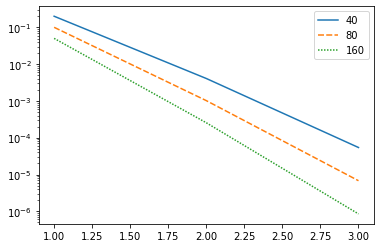

In [191]:
grid = sns.lineplot(data=QerrorsH1_df)
grid.set(xscale="linear", yscale="log")

In [135]:
QerrorsL2_df

,40,80,160
1,1.815441e-03,4.539573e-04,1.134953e-04
2,1.575503e-05,1.969835e-06,2.462438e-07
3,1.480865e-07,9.266789e-09,5.794884e-10


In [136]:
Qerrors_interpL2_df

,40,80,160
1,1.815441e-03,4.539573e-04,1.134953e-04
2,1.575503e-05,1.969835e-06,2.462438e-07
3,1.480865e-07,9.266789e-09,5.794884e-10


In [187]:
Qelapsed_time_df

,40,80,160
1,0:00:00.058449,0:00:00.176032,0:00:00.770131
2,0:00:00.119010,0:00:00.446479,0:00:01.804615
3,0:00:00.237913,0:00:00.954094,0:00:04.679822


In [188]:
elapsed_time_df

,40,80,160
1,0:00:00.179522,0:00:00.786902,0:00:02.312224
2,0:00:00.400928,0:00:02.155824,0:00:07.796583
3,0:00:01.549421,0:00:05.015535,0:00:19.248418


In [145]:
unknowns_df

,40,80,160
1,3243,12845,50925
2,12786,50875,202939
3,28630,114091,456043


In [146]:
Qunknowns_df

,40,80,160
1,1681,6561,25921
2,6561,25921,103041
3,14641,58081,231361


In [152]:
Qhmax_df

,40,80,160
1,0.035355,0.017678,0.008839
2,0.035355,0.017678,0.008839
3,0.035355,0.017678,0.008839


### Solve for the circle

Solve the problem in a circular region of radius R = 1, $\kappa = 1$, f = 1 and boundary conditions $u = 0$, for which the exact solution is

$$
\frac{1 - x_1^2 - x_2^2}{4}
$$

In [192]:
radius = 1
domain = Circle(Point(0,0), radius)
mesh_refinement = 10
order = 2
uexact = Expression("(1 - pow(x[0],2) - pow(x[1],2))/4", degree = 2)


# For remembering relevant info
Celapsed_time  = []
Cerrors1H1     = []
Cerrors1L2     = []
Cerrors2H1     = []
Cerrors2L2     = []
Cerrors_interp = []
Cunknowns      = []
Chmax          = []

# Order of finite elements space
orders = [1,2,3]
mesh_refinements = [40,80,160]

for io, order in enumerate(orders):
    Celapsed_time.append([])
    Cerrors1H1.append([])
    Cerrors1L2.append([])
    Cerrors2H1.append([])
    Cerrors2L2.append([])
    Cerrors_interp.append([])
    Cunknowns.append([])
    Chmax.append([])
    
    for im, mesh_refinement in enumerate(mesh_refinements):

        Pk = FiniteElement("Lagrange", 'triangle', order)
        mesh = generate_mesh(domain, mesh_refinement)


        # Finite element space
        W = FunctionSpace(mesh, Pk)


        ### Variational formulation: Poisson problem
        u = TrialFunction(W)
        v = TestFunction(W)

        funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
        dx = Measure("dx")(subdomain_data=funcdom)


        # Volumetric source
        f = Constant(1)

        a = inner(kappa*grad(u), grad(v))*dx
        L = f*v*dx

        #### Dirichlet boundary conditions on W
        bcs = DirichletBC(W, Constant(0), DomainBoundary())

        ### Solution
        w1 = Function(W)
        solve(a == L, w1, bcs)

        #print("\n With zeroed boundary condition")
        #print("| - Error L2 = ", errornorm(uexact, w1, 'L2'))
        #print("| - Error H1 = ", errornorm(uexact, w1, 'H1'))
                
        Cerrors1H1[io].append(errornorm(uexact, w1, 'H1'))
        Cerrors1L2[io].append(errornorm(uexact, w1, 'L2'))        

        Cunknowns[io].append( W.dim())
        Chmax[io].append(mesh.hmax())
       
        
        # Fixed boundary conditions, using exact values
        bcs = DirichletBC(W, uexact, DomainBoundary())

        ### Solution
        w2 = Function(W)

        solve(a == L, w2, bcs)

        #print("\n With true boundary condition")
        #print("| - Error L2 = ", errornorm(uexact, w2, 'L2'))
        #print("| - Error H1 = ", errornorm(uexact, w2, 'H1'))
        
        Cerrors2H1[io].append(errornorm(uexact, w2, 'H1'))
        Cerrors2L2[io].append(errornorm(uexact, w2, 'L2'))

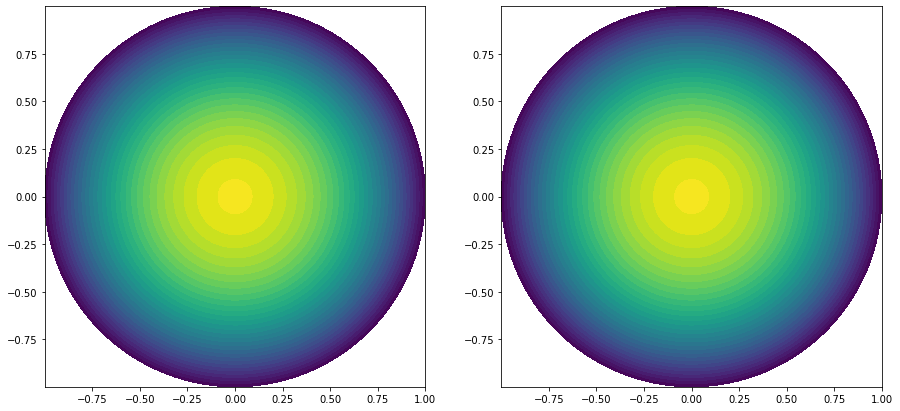

In [194]:
plt.figure(figsize=(15,15))
plt.subplot(121)
#plot(mesh, linewidth=.2)
plot(w2)

plt.subplot(122)
#plot(mesh, linewidth=.2)
plot(w1)

In [203]:
CerrorsL2_df  = pd.DataFrame(data = Cerrors1L2,
                            columns = mesh_refinements,
                            index = [1,2,3])


CerrorsH1_df  = pd.DataFrame(data = Cerrors1H1,
                            columns = mesh_refinements,
                            index = [1,2,3])

Cerrors2L2_df  = pd.DataFrame(data = Cerrors2L2,
                            columns = mesh_refinements,
                            index = [1,2,3])


Cerrors2H1_df  = pd.DataFrame(data = Cerrors2H1,
                            columns = mesh_refinements,
                            index = [1,2,3])

CerrorsL2_df

,40,80,160
1,0.000248,0.000062,0.000015
2,0.000186,0.000047,0.000012
3,0.000185,0.000046,0.000012


In [202]:
CerrorsH1_df

,40,80,160
1,0.010167,0.005070,0.002505
2,0.001829,0.000620,0.000228
3,0.001488,0.000525,0.000186


In [204]:
Cerrors2H1_df

,40,80,160
1,1.003393e-02,5.003364e-03,2.495532e-03
2,7.215833e-13,2.853964e-12,1.136096e-11
3,1.921608e-12,7.618397e-12,3.036043e-11


[None, None]

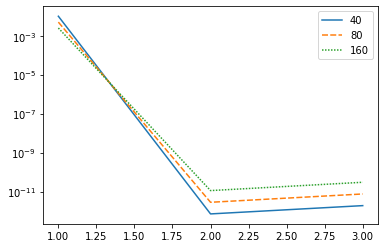

In [205]:
grid = sns.lineplot(data=Cerrors2H1_df)
grid.set(xscale="linear", yscale="log")

In [198]:
#Celapsed_time_df = pd.DataFrame(data = [[str(time) for time in el] for el in Celapsed_time],
#                            columns = mesh_refinements,
#                            index = [1,2,3])

CerrorsH1_df  = pd.DataFrame(data = Cerrors1H1,
                            columns = mesh_refinements,
                            index = [1,2,3])


CerrorsL2_df  = pd.DataFrame(data = Cerrors1L2,
                            columns = mesh_refinements,
                            index = [1,2,3])


Cerrors_interpL2_df  = pd.DataFrame(data = Cerrors_interp,
                                columns = mesh_refinements,
                                index = [1,2,3])


Cunknowns_df  = pd.DataFrame(data = Cunknowns,
                             columns = mesh_refinements,
                             index = [1,2,3])


Chmax_df  = pd.DataFrame(data = Chmax,
                             columns = mesh_refinements,
                             index = [1,2,3])

CerrorsH1_df

ValueError: 3 columns passed, passed data had 0 columns

### Bônus

In [ ]:

alpha = 1

# Define function spaces and mixed (product) space
V = FunctionSpace(mesh, "CG", 1)
R = FunctionSpace(mesh, "R", 0)
W = V * R

# Define variational problem
(u, l) = TrialFunction(W)
(v, d) = TestFunctions(W)
f = Expression("8*pow(pi,2)*cos(2*pi*x[0])*cos(2*pi*x[1])", degree = 5)
a = (inner(grad(u), grad(v)) + l*v)*dx
L = f*v*dx